<a href="https://colab.research.google.com/github/TMhdSofyan/Unsupervised_Learning/blob/main/Halibut_Field.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
! pip install jcopml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 KB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.1 MB/s eta 0:00:00
  Created wheel for jcopml: filename=jcopml-1.2.2-py2.py3-none-any.whl size=32195 sha256=5892eea680cbea3cfac6b2f64b679ce36a20b1c0218cdaac45ee8cad99d1f0d7
  Stored in directory: /root/.cache/pip/wheels/ea/b3/7d/0a33c9f0e642e714df1e619df91370950750a14afea5705565
Successfully built jcopml


In [3]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

In [4]:
df = pd.read_csv('/content/drive/MyDrive/01_Project_Reservoir_Description/Data/Data Halibut_train_2.csv')
df.head()

,CGR,DT5,GR,LLD,NPHI,RHOB,SP,FZI
0,50.2346,82.2500,61.7500,2.1878,0.1714,2.4292,3.4375,211.121914
1,48.9295,81.0521,65.1875,2.0287,0.1579,2.4840,3.7500,288.431455
2,50.2846,80.3333,63.5938,2.1020,0.1564,2.5329,4.0000,274.592462
3,41.7270,80.4405,50.8438,2.6891,0.1493,2.4641,3.8750,497.852972
4,35.1665,81.3095,46.6875,2.6994,0.1406,2.4272,3.8750,184.453837


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CGR     212 non-null    float64
 1   DT5     212 non-null    float64
 2   GR      212 non-null    float64
 3   LLD     212 non-null    float64
 4   NPHI    212 non-null    float64
 5   RHOB    212 non-null    float64
 6   SP      212 non-null    float64
 7   FZI     212 non-null    float64
dtypes: float64(8)
memory usage: 13.4 KB


In [7]:
df.describe().T

,CGR,DT5,GR,LLD,NPHI,RHOB,SP,FZI
count,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000
mean,45.527193,80.555180,55.701815,2.183180,0.155152,2.423432,2.329304,456.224651
std,25.355876,4.198972,26.504344,1.693759,0.047617,0.082279,1.412207,400.791802
min,14.081700,73.291700,27.562500,1.077300,0.081100,2.178400,-0.375000,4.503497
25%,27.555650,77.203500,36.343800,1.245250,0.123525,2.367575,1.375000,54.033758
50%,36.532200,80.420400,48.515650,1.494500,0.151200,2.406550,1.812500,364.007985
75%,59.120025,82.465075,66.656250,2.320500,0.172225,2.460900,3.875000,780.286831
max,130.376700,95.226200,139.875000,11.930300,0.379200,2.672900,4.937500,1536.150361


array([[<AxesSubplot:title={'center':'CGR'}>,
        <AxesSubplot:title={'center':'DT5'}>,
        <AxesSubplot:title={'center':'GR'}>],
       [<AxesSubplot:title={'center':'LLD'}>,
        <AxesSubplot:title={'center':'NPHI'}>,
        <AxesSubplot:title={'center':'RHOB'}>],
       [<AxesSubplot:title={'center':'SP'}>,
        <AxesSubplot:title={'center':'FZI'}>, <AxesSubplot:>]],
      dtype=object)

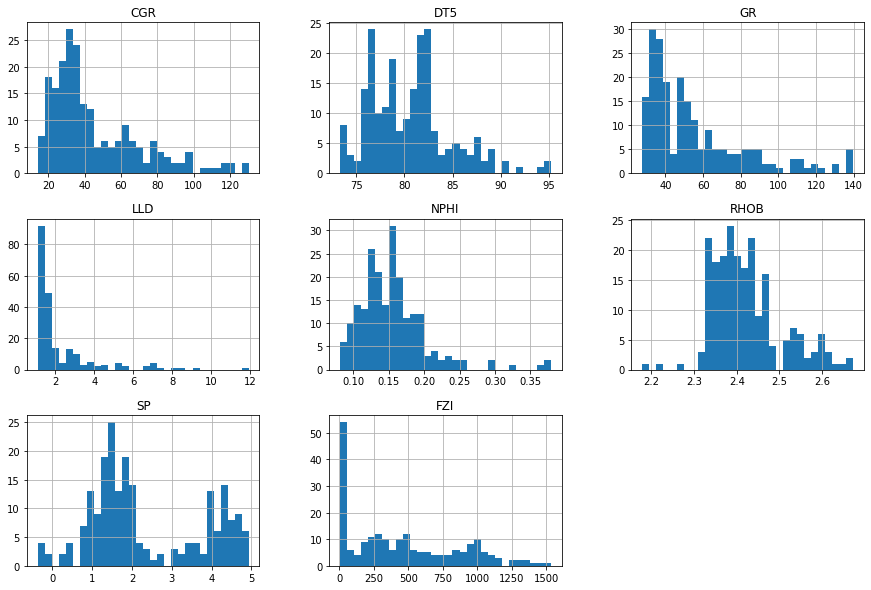

In [33]:
# more detailed look at the Univariate plots
df.hist(bins=30, figsize=(15,10))

<AxesSubplot:>

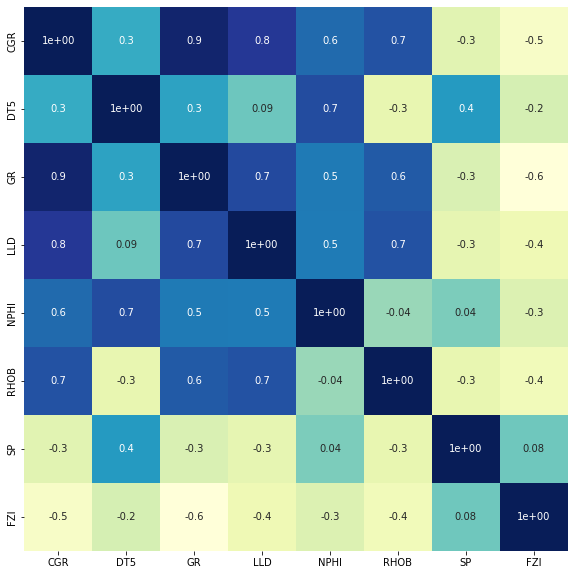

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 10))
sns.heatmap(df.corr(), cmap= "YlGnBu", cbar= False, annot= True, square= True, fmt= '.1')

In [11]:
X = df.drop(columns="FZI")
y = df.FZI

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((148, 7), (64, 7), (148,), (64,))

In [12]:
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gs
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [25]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='minmax', transform= 'yeo-johnson' , poly = 3), X.columns )])


from sklearn.ensemble import RandomForestRegressor
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestRegressor(n_jobs=-1, random_state=42))
])

model_RF = RandomizedSearchCV(pipeline, rsp.rf_poly_params, cv=3, n_iter=50,  n_jobs=-1, verbose=1, random_state=42)
model_RF.fit(X_train, y_train)

print(model_RF.best_params_)
print(model_RF.score(X_train, y_train), model_RF.best_score_, model_RF.score(X_test, y_test))

/usr/local/lib/python3.8/dist-packages/jcopml/pipeline/_pipeline.py:66: UserWarning: Transformer has default standardization, so the scaling argument is neglected
  warn("Transformer has default standardization, so the scaling argument is neglected")


Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__max_depth': 21, 'algo__max_features': 0.26364247048639056, 'algo__min_samples_leaf': 1, 'algo__n_estimators': 175, 'prep__numeric__poly__degree': 2, 'prep__numeric__poly__interaction_only': False}
0.9546686086121141 0.5471324621864959 0.6331490260526491


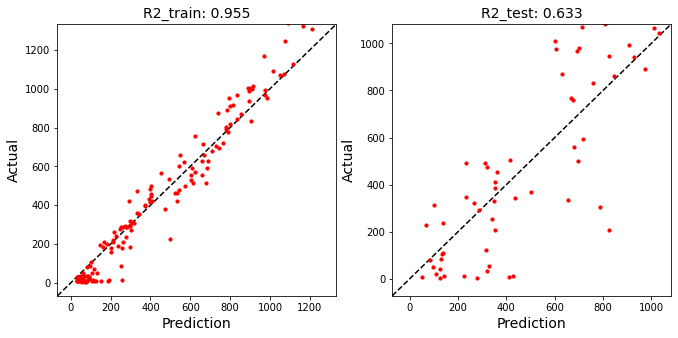

In [26]:
from jcopml.plot import plot_actual_vs_prediction, plot_residual
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, model_RF)

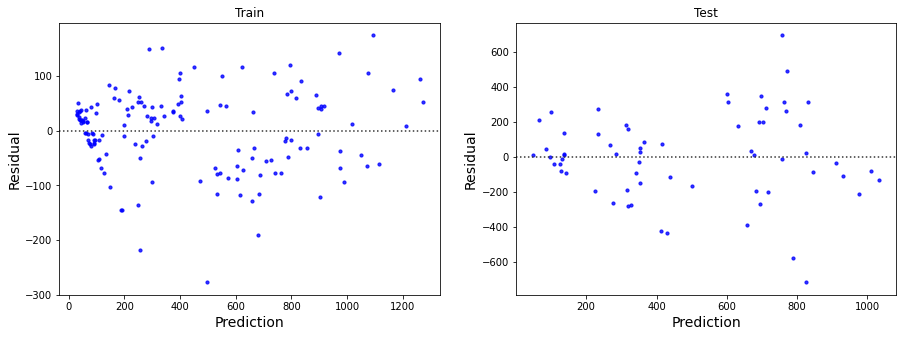

In [27]:
plot_residual(X_train, y_train, X_test, y_test, model_RF)

In [21]:
from sklearn.neural_network import MLPRegressor

preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='robust', transform= 'yeo-johnson', poly = 3), X.columns )])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('mlp', MLPRegressor(random_state=42))
])

parameter = {
    "mlp__alpha": [0.0001, 0.0003, 0.001, 0.003, 0.01],
    "mlp__hidden_layer_sizes": [(16, 4, 2), (8, 2), (4, 2)],
    "mlp__learning_rate_init": [0.001, 0.005, 0.01],
    "mlp__activation": ["identity"]
}

model_ANN = RandomizedSearchCV(pipeline, parameter, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model_ANN.fit(X_train, y_train)

print(model_ANN.best_params_)
print(model_ANN.score(X_train, y_train), model_ANN.best_score_, model_ANN.score(X_test, y_test))

/usr/local/lib/python3.8/dist-packages/jcopml/pipeline/_pipeline.py:66: UserWarning: Transformer has default standardization, so the scaling argument is neglected
  warn("Transformer has default standardization, so the scaling argument is neglected")
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 36 is smaller than n_iter=50. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 36 candidates, totalling 108 fits
{'mlp__learning_rate_init': 0.01, 'mlp__hidden_layer_sizes': (16, 4, 2), 'mlp__alpha': 0.003, 'mlp__activation': 'identity'}
0.5698521158928358 0.41628766586557076 0.5921595160954195


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


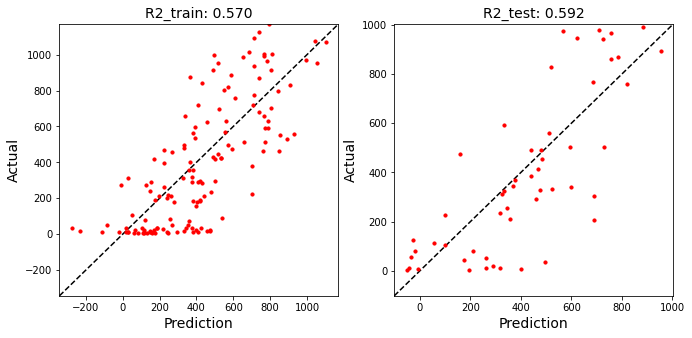

In [22]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, model_ANN)

In [30]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='minmax', transform= 'yeo-johnson', poly = 1), X.columns )])


from xgboost import XGBRegressor
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])


model_XGB = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=2, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model_XGB.fit(X_train, y_train)

print(model_XGB.best_params_)
print(model_XGB.score(X_train, y_train), model_XGB.best_score_, model_XGB.score(X_test, y_test))

/usr/local/lib/python3.8/dist-packages/jcopml/pipeline/_pipeline.py:66: UserWarning: Transformer has default standardization, so the scaling argument is neglected
  warn("Transformer has default standardization, so the scaling argument is neglected")


Fitting 2 folds for each of 50 candidates, totalling 100 fits
{'algo__colsample_bytree': 0.3729389632059006, 'algo__gamma': 5, 'algo__learning_rate': 0.11078641782934492, 'algo__max_depth': 5, 'algo__n_estimators': 159, 'algo__reg_alpha': 0.007299348683062313, 'algo__reg_lambda': 0.3101429427212744, 'algo__subsample': 0.342673732496884}
0.997304124369488 0.4292929994820481 0.45154441561679826


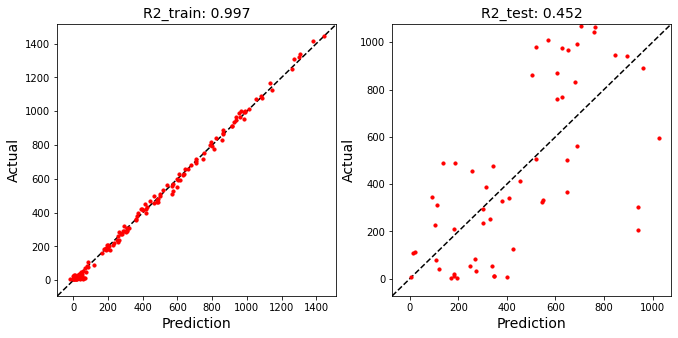

In [31]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, model_XGB)

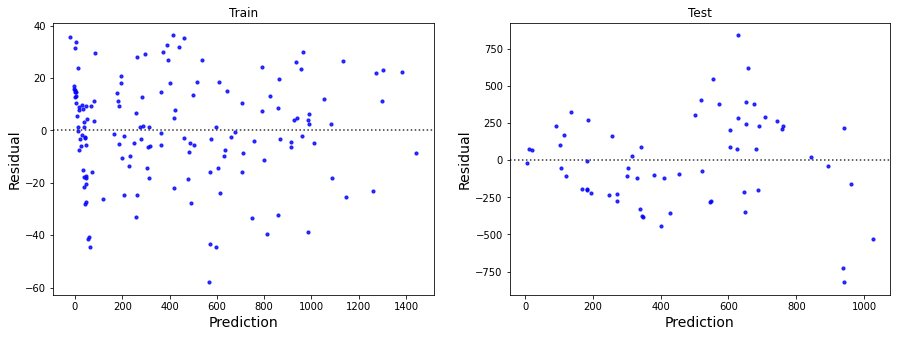

In [32]:
plot_residual(X_train, y_train, X_test, y_test, model_XGB)